# **Roberta Sentinel Model Building ON Research Abstract (Computer Science)**

### This notebook contains the code for building the Roberta Sentinel model. The model is trained on the ChatGPT and OpenWeb datasets. The model is then evaluated on the test set and the metrics are calculated. The model is then saved to a file.

# 0. Read te Original Dataset


### 0.1 The original dataset is read from the jsonl files and converted to a pandas dataframe. We then label the ChatGPT data as 1 and OpenWeb as 0, and combine them together to become one dataframe.

In [6]:
import pandas as pd
import json

GPT = []
HUM = []

for i in range(1,4):
    with open(f'dataset/UnSeenTesting/CS_Task{i}/gpt.json', 'r') as gpt_file:
        gpt = json.load(gpt_file)
    with open(f'dataset/UnSeenTesting/CS_Task{i}/hum.json', 'r') as hum_file:
        hum = json.load(hum_file)

    gpt = pd.DataFrame(list(gpt.items()), columns=['Paper ID', 'text'])
    hum = pd.DataFrame(list(hum.items()), columns=['Paper ID', 'text'])
    GPT.append(gpt)
    HUM.append(hum)

GPT = pd.concat(GPT, ignore_index=True)
HUM = pd.concat(HUM, ignore_index=True)

GPT['label'] = 1
HUM['label'] = 0

combined_df = pd.concat([GPT, HUM], ignore_index=True)
# sampling combined_df to have 100 rows
# combined_df = combined_df.sample(n=1000, random_state=1)
combined_df.head()

,Paper ID,text,label
0,1905.02253,"This paper presents Bee$^+$, a novel insect-sc...",1
1,2010.14244,This paper proposes a novel approach for enabl...,1
2,2011.00330,This paper proposes a novel approach to overco...,1
3,2011.02250,This paper provides a comprehensive review of ...,1
4,2102.04525,The paper presents a novel loss function calle...,1


In [7]:
print(combined_df.shape)
combined_df['label'].value_counts()

(300000, 3)


1    150000
0    150000
Name: label, dtype: int64

### 0.2 In this section, we preprocess the Dataset. We extract the hidden states from all of the text by using Roberta Model. We then have the X and y values for the model.

In [8]:
import torch
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaModel
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaModel.from_pretrained("roberta-base").to(device)

def extract_features(text):
    tokenized_text = tokenizer.encode(text, truncation=True, max_length=512, return_tensors="pt").to(device)
    with torch.no_grad():  # This ensures that gradients are not computed during feature extraction
        outputs = model(tokenized_text)
    last_hidden_states = outputs.last_hidden_state
    TClassification = last_hidden_states[:, 0, :].squeeze().detach().cpu().numpy()
    return TClassification

# Assuming you have a dataframe combined_df with a 'text' column and a 'label' column
features = combined_df['text'].apply(extract_features)
labels = combined_df['label'].tolist()

# Convert extracted features to a format suitable for PyTorch
X = np.array(features.tolist())
y = np.array(labels)
X, y

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(array([[-0.05347859,  0.11597   , -0.02494537, ..., -0.01882863,
         -0.01475937, -0.04508946],
        [-0.01116272,  0.13642767, -0.02407675, ..., -0.04282609,
         -0.01545086, -0.01788665],
        [-0.00138635,  0.10704626, -0.03006044, ..., -0.04758251,
         -0.03454416, -0.04916456],
        ...,
        [-0.00909584,  0.10792923, -0.03551263, ..., -0.05389938,
         -0.02760921, -0.02122538],
        [-0.01292058,  0.10996538, -0.02999117, ...,  0.01445051,
         -0.01894157,  0.00396793],
        [ 0.01771462,  0.10447737, -0.04074348, ..., -0.04236715,
         -0.01934409, -0.03138739]], dtype=float32),
 array([1, 1, 1, ..., 0, 0, 0]))

### 0.3 The Preprocessed Dataset is saved to a csv file for usages later.

In [23]:
combined_df['extracted_features'] = features
combined_df['label'] = labels

# Save the DataFrame to CSV
combined_df.to_csv('CS-Abstract-Combined-Preprocessed-Dataset.csv', index=False)

ValueError: Length of values (444) does not match length of index (300000)

# 1. Train, Validation, and Test Split

### 1.1 The preprocessed dataset is read from the csv file. The extracted features are converted from string representation of lists into actual lists of numbers. The lists of numbers are then converted into numpy arrays. The labels are also converted into numpy arrays.

In [1]:
import pandas as pd
import numpy as np
# Load the data
combined_df = pd.read_csv('dataset/CS-Abstract-Combined-Preprocessed-Dataset.csv')

# Convert the string representation of lists into actual lists of numbers
X = combined_df['extracted_features'].str.replace('\n', '').str.strip('[]').str.split().apply(lambda x: [float(i) for i in x])

# Convert lists of numbers into numpy arrays
X = np.array(X.tolist())

# Get the labels as a numpy array
y = np.array(combined_df['label'].tolist())

X, y

(array([[-0.05347859,  0.11597   , -0.02494537, ..., -0.01882863,
         -0.01475937, -0.04508946],
        [-0.01116272,  0.13642767, -0.02407675, ..., -0.04282609,
         -0.01545086, -0.01788665],
        [-0.00138635,  0.10704626, -0.03006044, ..., -0.04758251,
         -0.03454415, -0.04916456],
        ...,
        [-0.00909584,  0.10792923, -0.03551263, ..., -0.05389938,
         -0.02760921, -0.02122538],
        [-0.01292058,  0.10996538, -0.02999117, ...,  0.01445051,
         -0.01894157,  0.00396793],
        [ 0.01771462,  0.10447737, -0.04074348, ..., -0.04236715,
         -0.01934409, -0.03138739]]),
 array([1, 1, 1, ..., 0, 0, 0]))

In [2]:
combined_df.head()

,Paper ID,text,label,extracted_features
0,1905.02253,"This paper presents Bee$^+$, a novel insect-sc...",1,[-5.34785949e-02 1.15970001e-01 -2.49453727e-...
1,2010.14244,This paper proposes a novel approach for enabl...,1,[-1.11627234e-02 1.36427671e-01 -2.40767486e-...
2,2011.00330,This paper proposes a novel approach to overco...,1,[-1.38635410e-03 1.07046261e-01 -3.00604366e-...
3,2011.02250,This paper provides a comprehensive review of ...,1,[-4.02924139e-03 1.25577912e-01 -2.42507644e-...
4,2102.04525,The paper presents a novel loss function calle...,1,[-1.11521436e-02 1.01311266e-01 -3.34746987e-...


In [3]:
X.shape

(300000, 768)

### 1.2 The data is split into train, validation, and test sets. The train set is 70% of the data, the validation set is 10% of the data, and the test set is 20% of the data. Validation set is used to tune the hyperparameters of the model. The test set is used to evaluate the model.

In [4]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset

# Split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

# 2. Model Building

### 2.1 The model is defined as a simple MLP model with 2 hidden layers. The model is trained on the train set and validated on the validation set. The model is trained for 15 epochs with a batch size of 512.

In [6]:
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define a simple MLP model
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 2)
        self.gelu = nn.GELU()

    def forward(self, x):
        x = self.gelu(self.fc1(x))
        x = self.fc2(x)
        return x


mlp_model = MLP(X_train.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(mlp_model.parameters(), lr=1e-4, weight_decay=1e-3)

### 2.2 The model is trained for 15 epochs with a batch size of 512. The training loss and validation loss are plotted to see if the model is overfitting or not.

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, det_curve

# Train the model
epochs = 15
batch_size = 512

# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_precisions = []
val_precisions = []
train_f1s = []
val_f1s = []

for epoch in range(epochs):
    mlp_model.train()
    running_loss = 0.0
    all_train_predictions = []
    all_train_labels = []

    for inputs, labels in DataLoader(train_dataset, batch_size=batch_size, shuffle=True):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = mlp_model(inputs.float())
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        all_train_predictions.extend(predicted.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

    train_losses.append(running_loss/len(train_dataset))

    train_accuracy = np.mean(np.array(all_train_predictions) == np.array(all_train_labels))
    train_precision = precision_score(all_train_labels, all_train_predictions)
    train_f1 = f1_score(all_train_labels, all_train_predictions)

    train_accuracies.append(train_accuracy)
    train_precisions.append(train_precision)
    train_f1s.append(train_f1)

    # Validation logic
    mlp_model.eval()
    val_loss = 0.0
    all_val_predictions = []
    all_val_labels = []

    with torch.no_grad():
        for inputs, labels in DataLoader(val_dataset, batch_size=batch_size):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = mlp_model(inputs.float())
            _, predicted = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            all_val_predictions.extend(predicted.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

    val_losses.append(val_loss/len(val_dataset))

    val_accuracy = np.mean(np.array(all_val_predictions) == np.array(all_val_labels))
    val_precision = precision_score(all_val_labels, all_val_predictions)
    val_f1 = f1_score(all_val_labels, all_val_predictions)

    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracy:.4f}, Train Precision: {train_precision:.4f}, Train F1: {train_f1:.4f}")
    print(f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}, Val Precision: {val_precision:.4f}, Val F1: {val_f1:.4f}")
    print('-----------------------------------')

Epoch 1/15
Train Loss: 0.0010, Train Accuracy: 0.7991, Train Precision: 0.7931, Train F1: 0.8011
Val Loss: 0.0007, Val Accuracy: 0.8557, Val Precision: 0.8721, Val F1: 0.8540
-----------------------------------
Epoch 2/15
Train Loss: 0.0006, Train Accuracy: 0.8771, Train Precision: 0.8841, Train F1: 0.8759
Val Loss: 0.0005, Val Accuracy: 0.8894, Val Precision: 0.9054, Val F1: 0.8883
-----------------------------------
Epoch 3/15
Train Loss: 0.0005, Train Accuracy: 0.8979, Train Precision: 0.9043, Train F1: 0.8971
Val Loss: 0.0005, Val Accuracy: 0.9014, Val Precision: 0.8961, Val F1: 0.9030
-----------------------------------
Epoch 4/15
Train Loss: 0.0004, Train Accuracy: 0.9071, Train Precision: 0.9125, Train F1: 0.9064
Val Loss: 0.0004, Val Accuracy: 0.9097, Val Precision: 0.9082, Val F1: 0.9108
-----------------------------------
Epoch 5/15
Train Loss: 0.0004, Train Accuracy: 0.9126, Train Precision: 0.9178, Train F1: 0.9121
Val Loss: 0.0004, Val Accuracy: 0.9135, Val Precision: 0.91

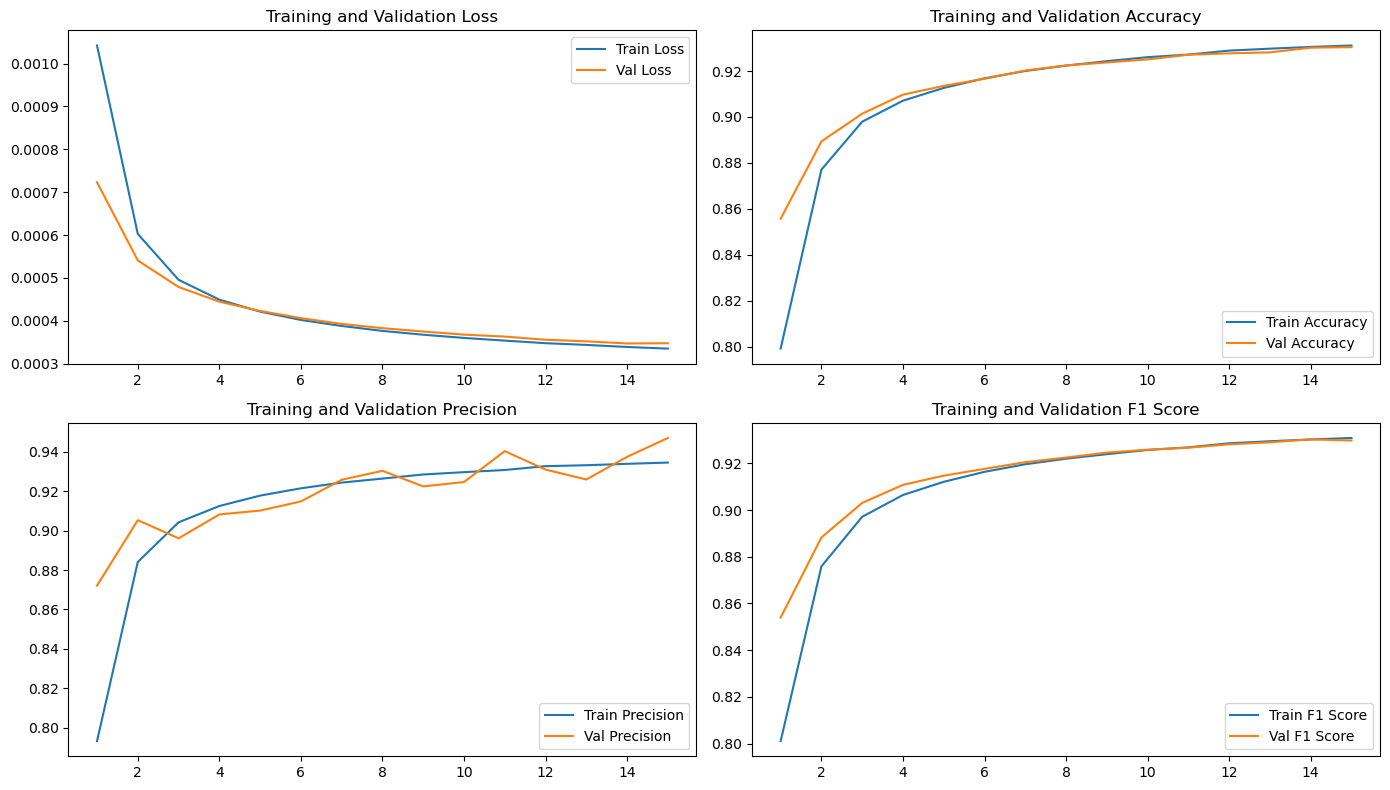

In [8]:
import matplotlib.pyplot as plt

# Plot metrics
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(14, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Val Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 3)
plt.plot(epochs_range, train_precisions, label='Train Precision')
plt.plot(epochs_range, val_precisions, label='Val Precision')
plt.legend(loc='lower right')
plt.title('Training and Validation Precision')

plt.subplot(2, 2, 4)
plt.plot(epochs_range, train_f1s, label='Train F1 Score')
plt.plot(epochs_range, val_f1s, label='Val F1 Score')
plt.legend(loc='lower right')
plt.title('Training and Validation F1 Score')

plt.tight_layout()
plt.show()

### The model does not seems to be a bit overfitting. There is no significant sign of accuracy, precision, and F1 score decreasing or loss increasing. The model is trained for 15 epochs, but it seems that the model is not overfitting yet. The model can be trained for more epochs to see if the model is overfitting or not.

# 3. Model Evaluation

### 3.1 The model is evaluated on the test set. The accuracy, precision, recall, and F1 score are calculated.

Accuracy: 0.928
Precision: 0.944
Recall: 0.910
F1 Score: 0.927
False Positive Rate: 0.08964456481760123
False Negative Rate: 0.05413219021034792


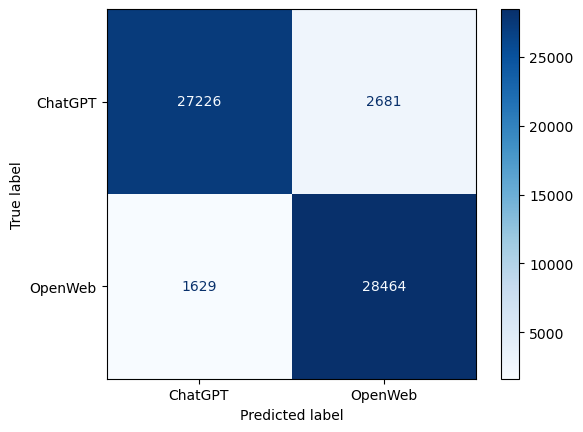

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, det_curve, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import torch.nn.functional as F
# Evaluate the model and calculate metrics
mlp_model.eval()
all_labels = []
all_predictions = []
all_probabilities = []

with torch.no_grad():
    for inputs, labels in DataLoader(test_dataset, batch_size=batch_size):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = mlp_model(inputs.float())
        _, predicted = torch.max(outputs, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probabilities.extend(F.softmax(outputs, dim=1)[:, 1].cpu().numpy())  # Get probabilities for class 1

CM = confusion_matrix(all_labels, all_predictions)
# Make ChatGPT as positive class
CM = np.array([[CM[1][1], CM[1][0]], [CM[0][1], CM[0][0]]])
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)
FPR = CM[0][1] / (CM[0][1] + CM[0][0])
FNR = CM[1][0] / (CM[1][0] + CM[1][1])

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"False Positive Rate: {FPR}")
print(f"False Negative Rate: {FNR}")


# Plot CM and show data labels
disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=['ChatGPT', 'OpenWeb'])
disp.plot(cmap='Blues', values_format='d')

### 3.2 The ROC curve and AUC are calculated and plotted. It seems that the model is performing extremely well.

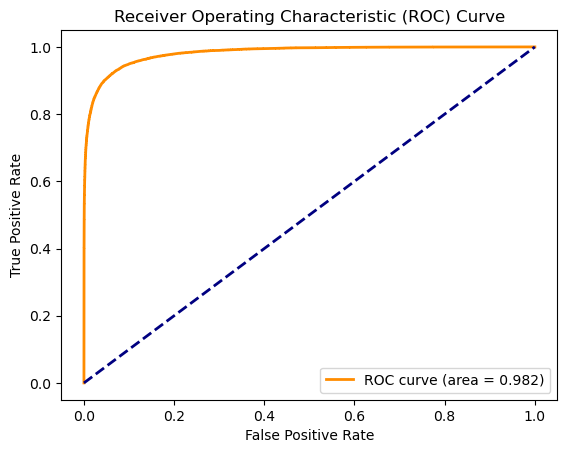

In [10]:
from sklearn.metrics import roc_curve, auc
# ROC Curve and AUC
fpr, tpr, _ = roc_curve(all_labels, all_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


### 3.3 The DET curve is calculated and plotted. It also seems to indicate that the model is performing extremely well, since the curve is very close to the ideal curve.

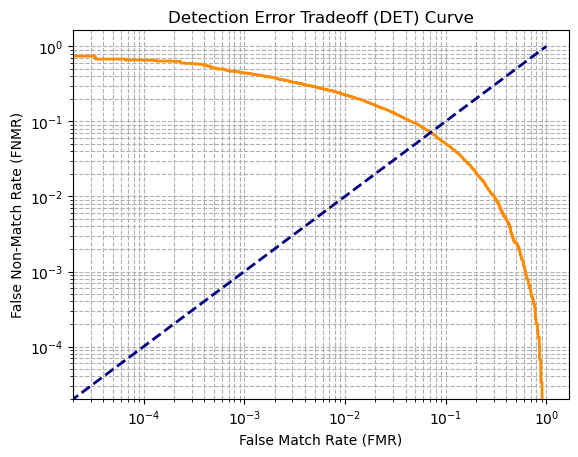

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(all_labels, all_probabilities)

# Compute False Match Rate and False Non-Match Rate
fmr = fpr
fnmr = 1 - tpr

# Plot the DET curve
plt.figure()
plt.plot(fmr, fnmr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('False Match Rate (FMR)')
plt.ylabel('False Non-Match Rate (FNMR)')
plt.title('Detection Error Tradeoff (DET) Curve')
plt.grid(True, which="both", ls="--")
plt.show()


### 3.4 Save the model to a file for future usages.

In [12]:
# Save Model
torch.save(mlp_model.state_dict(), 'CSAbstractRobertaSentinel.pth')

# 4. Conclusion

### The Roberta Sentinel model is trained on the ChatGPT and OpenWeb datasets. The model is then evaluated on the test set and the metrics are calculated along side with the ROC curve and DET curve. So far, all of the results follows the GPT-Sentinel Report. The model seems to be performing extremely well, and the evaluation metrics indicate that the model is performing well. In addition, There is no obvious sign of overfitting as well.
### However, this model should be tested on more datasets to see if the model is actually performing well or not.